# BAYTAP-08 Demo 
Uses earthscopestraintools library to

- download strainmeter data and pressure data in miniseed format

- convert raw data to units of strain

- detrend and automatically estimate and remove offsets to create inputs for BAYTAP-08

- use BAYTAP-08 to calculate the tidal constituents and pressure response coefficients 

- generate and remove trend, tidal (using SPOTL), pressure, and offset correction time series from original data

Not yet implemented here:

- calculate signal-to-noise ratio for M2 and O1 tidal bands

- containerized use of Cleanstrain+ for offset removal

In [1]:
from earthscopestraintools.mseed_tools import ts_from_mseed
from earthscopestraintools.gtsm_metadata import GtsmMetadata
from earthscopestraintools.timeseries import plot_timeseries_comparison


import logging
logger = logging.getLogger()
logging.basicConfig(
        format="%(message)s", level=logging.INFO
    )

## Download and prepare data
For BAYTAP, we want at least 3 months of continuous (non-gappy) strain and barometric pressure data

In [2]:
#select a network, station, and time window
network = 'PB'
station = 'B073'
start="2015-07-01T00:00:00"
end = "2015-10-01T00:00:00"

#load the metadata for the station
meta = GtsmMetadata(network,station)

#### Uncorrected Strain data

PB B073 Loading T0 RS* from 2015-07-01T00:00:00 to 2015-10-01T00:00:00 from Earthscope DMC miniseed


    Trace 1. 2015-07-01T00:00:00.000000Z:2015-10-01T00:00:00.000000Z mapping RS1 to CH0
    Trace 2. 2015-07-01T00:00:00.000000Z:2015-10-01T00:00:00.000000Z mapping RS2 to CH1
    Trace 3. 2015-07-01T00:00:00.000000Z:2015-10-01T00:00:00.000000Z mapping RS3 to CH2
    Trace 4. 2015-07-01T00:00:00.000000Z:2015-10-01T00:00:00.000000Z mapping RS4 to CH3
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
  Converting 999999 gap fill values to nan
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
PB.B073.T0.RS*
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2015-07-01 00:00:00 - 2015-10-01 00:00:00        | Period:         600.0s
    | Series:         raw| Units:        counts| Level:          0| Gaps:             0.0% 
    | Epochs:       13249| Good:        13249.0| Missing:      0.0| Interpolated:      0.0
    | Samples:      52996| Good:          

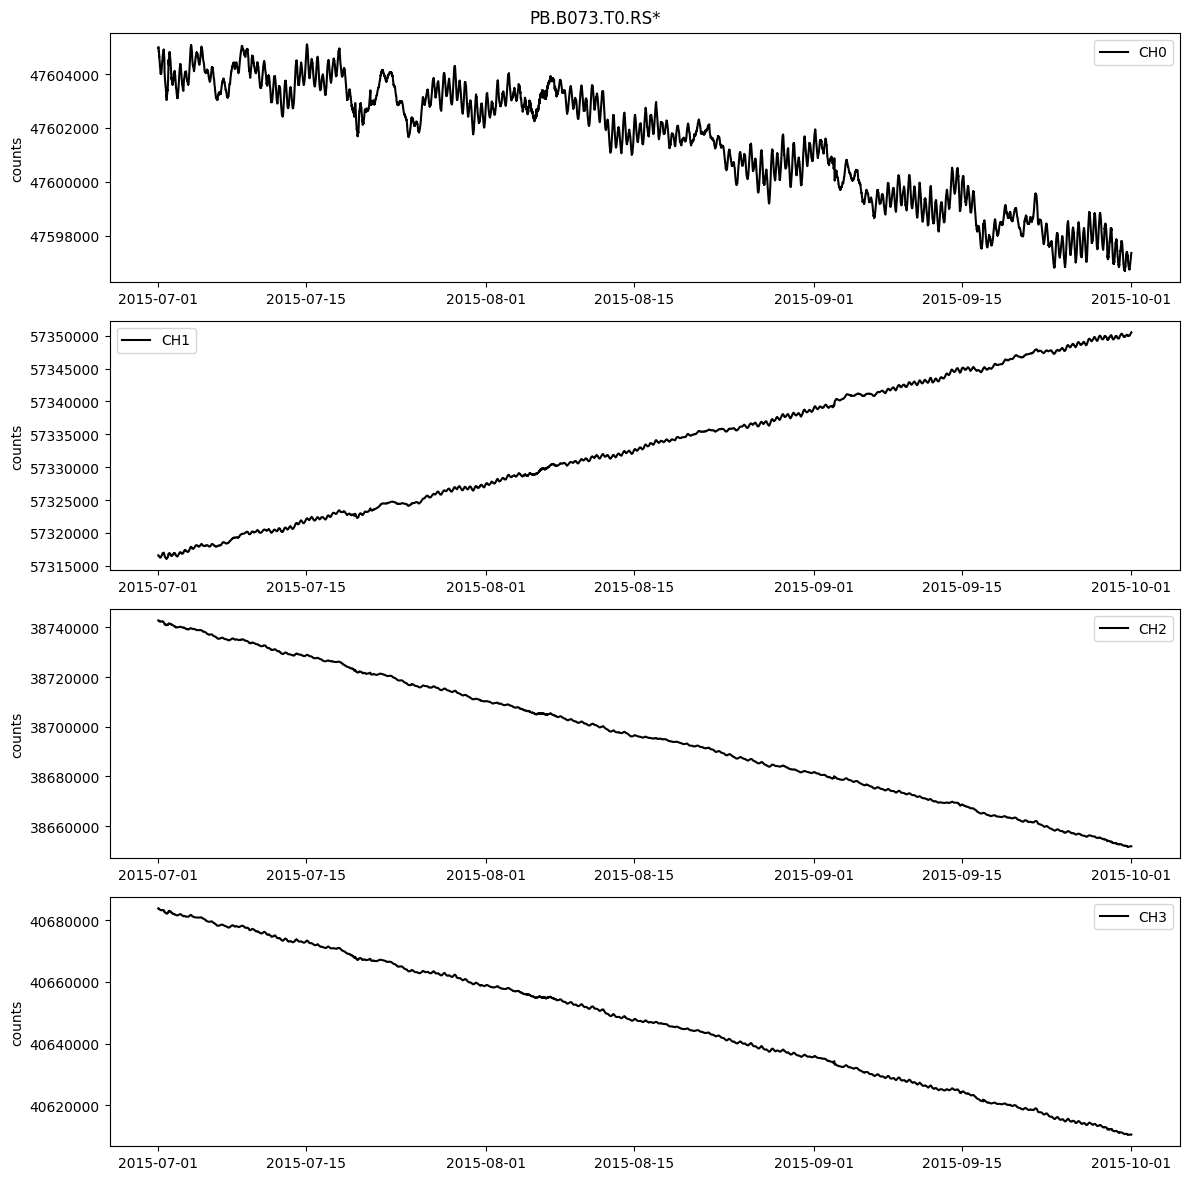

In [3]:
#load some 10 min data from miniseed, and view stats/plot
gauge_raw = ts_from_mseed(network=network, station=station, location='T0', channel='RS*', start=start, end=end)
gauge_raw.stats()
gauge_raw.plot()

In [4]:
#apply a 2 hr lowpass butterworth filter to the data
name = f"{network}.{station}.gauge.filtered"
filt_cutoff_s = 2*60*60
gauge_filtered = gauge_raw.butterworth_filter(name=name, 
                                              filter_type='lowpass',
                                              filter_order=5,
                                              filter_cutoff_s=filt_cutoff_s)
#gauge_filtered.stats()
#gauge_filtered.plot()

Applying Butterworth Filter
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


In [5]:
#decimate to hourly data, as this is sufficiently sampled for BAYTAP tidal/pressure analysis
name = f"{network}.{station}.gauge.decimated"
gauge_decimated = gauge_filtered.decimate_to_hourly(name=name)
gauge_decimated.stats()
#gauge_decimated.plot()

Decimating to hourly
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
PB.B073.gauge.decimated
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2015-07-01 00:00:00 - 2015-10-01 00:00:00        | Period:          3600s
    | Series:            | Units:        counts| Level:          1| Gaps:             0.0% 
    | Epochs:        2209| Good:         2209.0| Missing:      0.0| Interpolated:      0.0
    | Samples:       8836| Good:           8836| Missing:        0| Interpolated:        0


Converting raw counts to microstrain


    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
PB.B073.gauge.microstrain
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2015-07-01 00:00:00 - 2015-10-01 00:00:00        | Period:          3600s
    | Series: microstrain| Units:   microstrain| Level:          1| Gaps:             0.0% 
    | Epochs:        2209| Good:         2209.0| Missing:      0.0| Interpolated:      0.0
    | Samples:       8836| Good:           8836| Missing:        0| Interpolated:        0


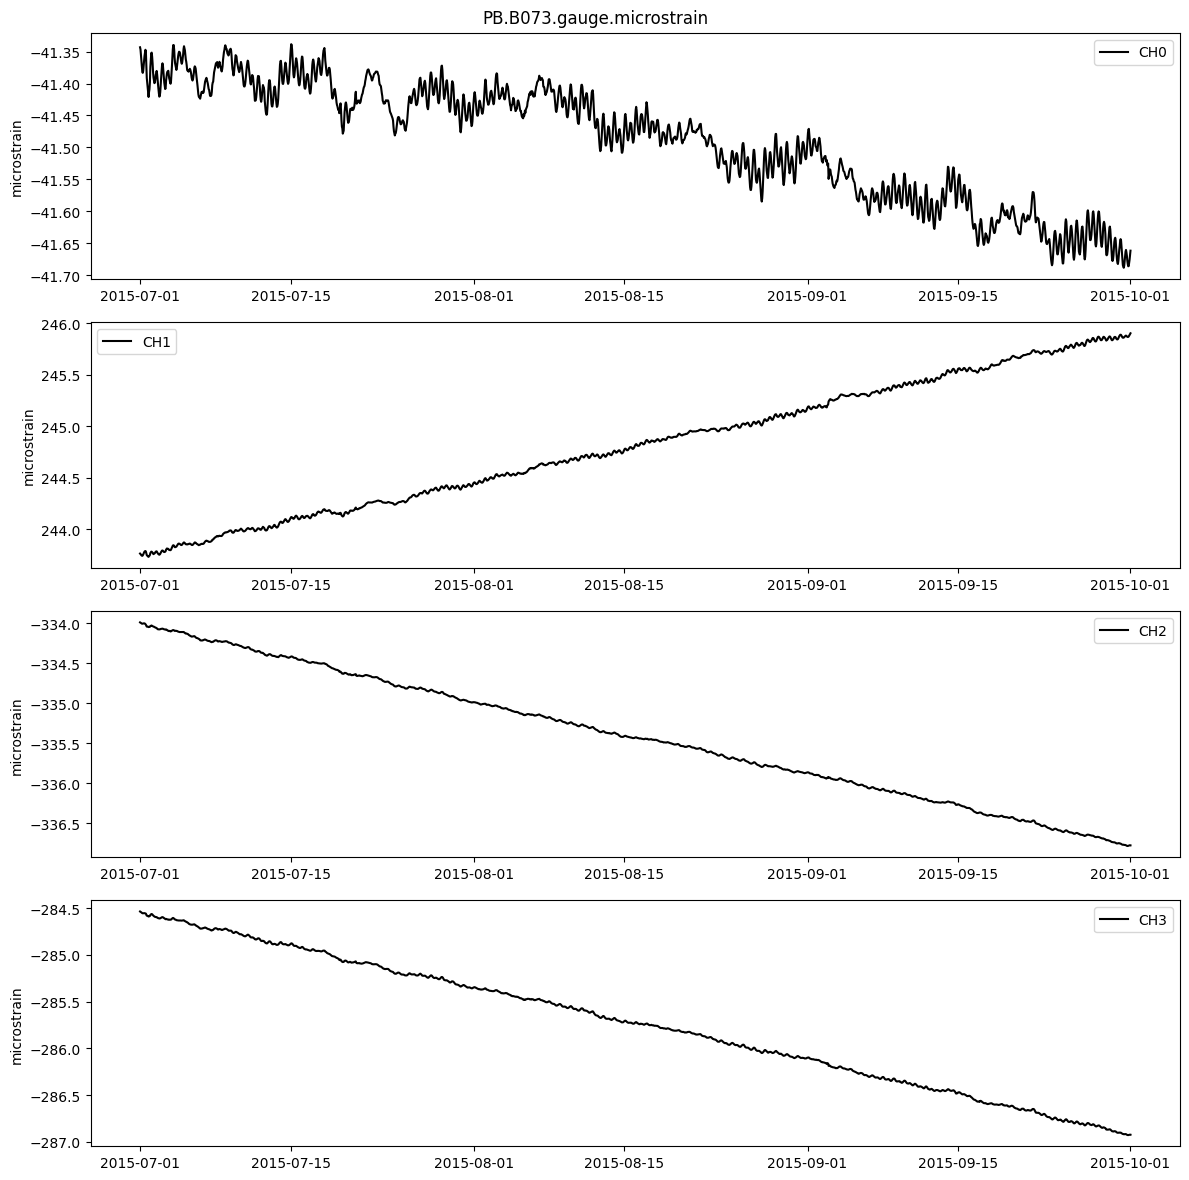

In [6]:
#convert digital counts to microstrain (Linearization) using some initial reference strains and physical information about the instrument
name = f"{network}.{station}.gauge.microstrain"
gauge_microstrain = gauge_decimated.linearize(reference_strains=meta.reference_strains, gap=meta.gap, name=name)
gauge_microstrain.stats()
gauge_microstrain.plot()

#### Initial trend correction

Calculating linear trend correction
    Trend Start: 2015-07-01 00:00:00
    Trend End: 2015-10-01 00:00:00
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


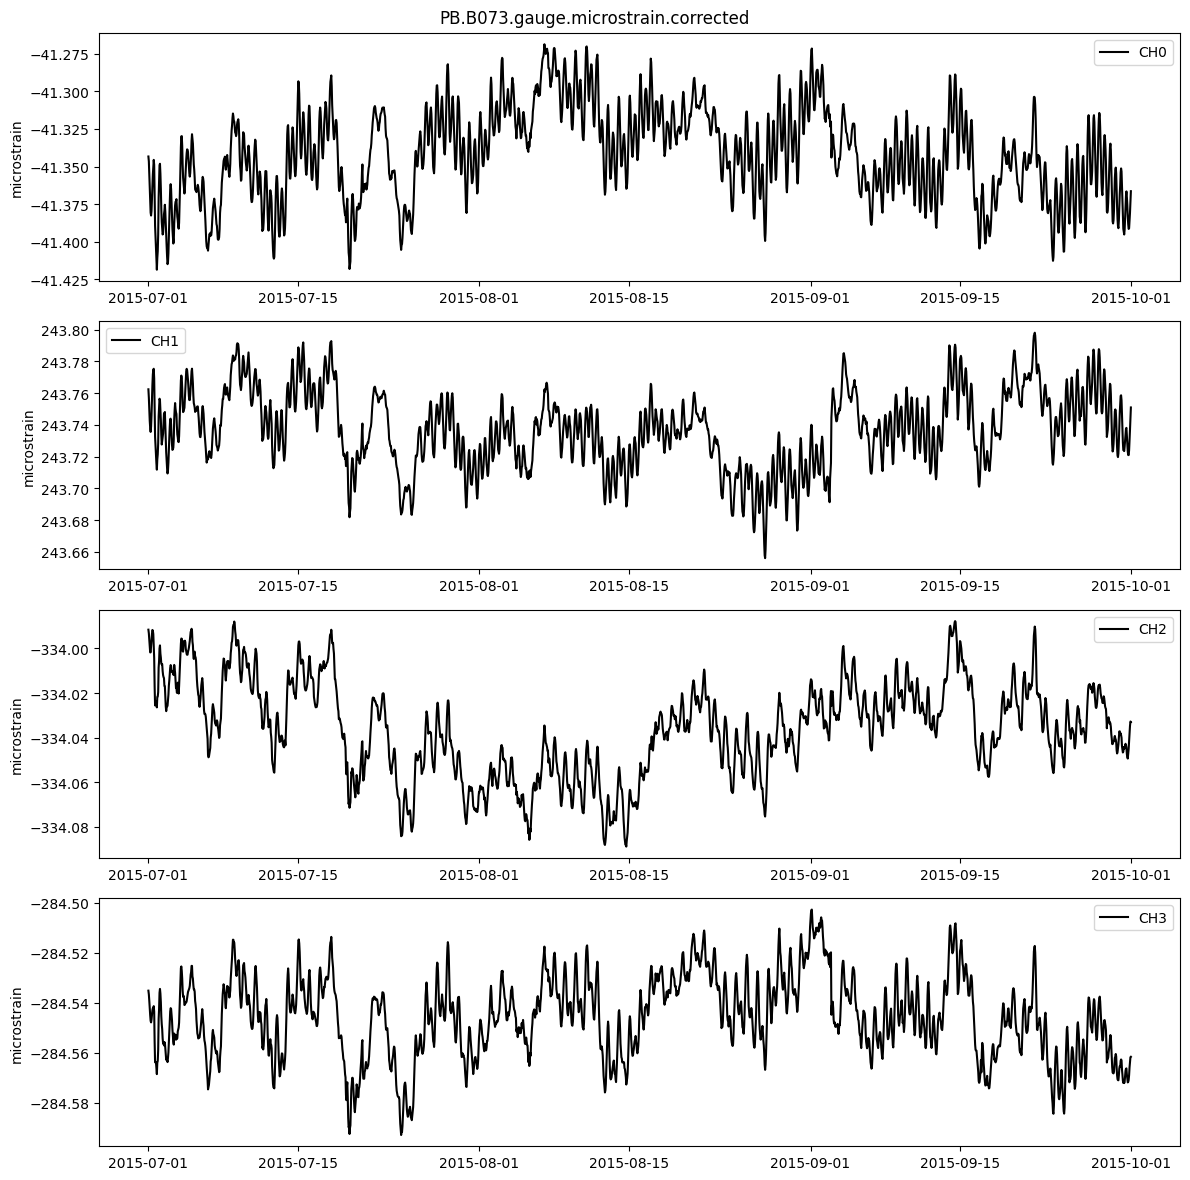

In [7]:
name = f"{network}.{station}.gauge.trend_c"
trend_c = gauge_microstrain.linear_trend_correction(name=name)
trend_corrected = gauge_microstrain.apply_corrections([trend_c])
trend_corrected.plot()

#### Initial offset correction
Offsets in this section are automatically detected via a simple first differencing algorithm. The best approach is to first correct for other known changes (tides, pressure, trend), then to apply the calculate_offsets function. This function finds jumps between consecutive datapoints that are above a cutoff limit, which is assigned from a user-specified value multiplied by a user-specified percentile of all first differences calculated for the gauge. For example, if a multiplier of 10 and percentile of 75% are used on a dataset whose first difference 75th percentile is 2 nanostrain, any jump in the data above 20 nanostrain will be flagged as an offset. This method is not perfect, but works well for certain situations.


Calculating offsets using cutoff percentile of 0.75 and limit multiplier of 10.
Using offset limits of [0.036702, 0.027049, 0.013494, 0.015453]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


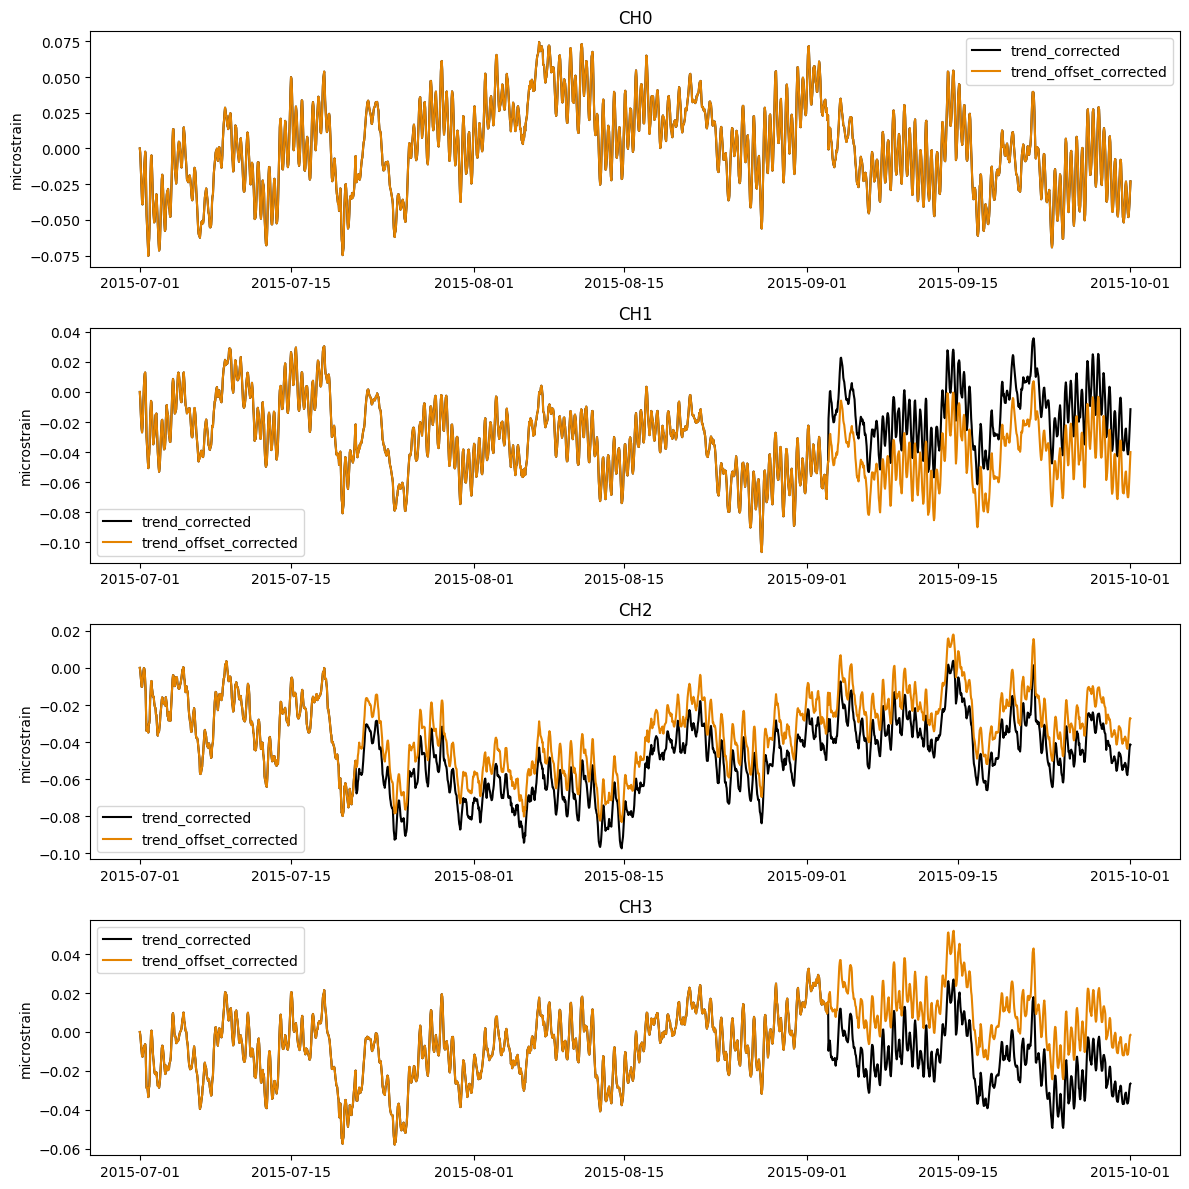

In [8]:
name = f"{network}.{station}.gauge.offset_c"
offset_c = trend_corrected.calculate_offsets(limit_multiplier=10, cutoff_percentile=0.75, name=name)
trend_offset_corrected = trend_corrected.apply_corrections([offset_c])
#offset_c.plot()
plot_timeseries_comparison([trend_corrected, trend_offset_corrected], 
                           names=['trend_corrected', 'trend_offset_corrected',], 
                           zero=True)

#### Barometric Pressure Data

In [9]:
#download and prepare atmospheric pressure data, sampled at 30m by GTSM 
atmp_raw = ts_from_mseed(network=network, 
                         station=station, 
                         location='TS', 
                         channel='RDO', 
                         period=1800, 
                         start=start, 
                         end=end,
                         scale_factor=0.001, 
                         units='hPa')
atmp_raw.stats()
#atmp_raw.plot()

PB B073 Loading TS RDO from 2015-07-01T00:00:00 to 2015-10-01T00:00:00 from Earthscope DMC miniseed
    Trace 1. 2015-07-01T00:00:00.000000Z:2015-10-01T00:00:00.000000Z mapping RDO to atmp
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
  Converting 999999 gap fill values to nan
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
PB.B073.TS.RDO
    | Channels: ['atmp']                                 
    | TimeRange: 2015-07-01 00:00:00 - 2015-10-01 00:00:00        | Period:        1800.0s
    | Series:         raw| Units:           hPa| Level:          0| Gaps:             0.0% 
    | Epochs:        4417| Good:         4417.0| Missing:      0.0| Interpolated:      0.0
    | Samples:       4417| Good:           4417| Missing:        0| Interpolated:        0


Decimating to hourly
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
PB.B073.atmp.decimated
    | Channels: ['atmp']                                 
    | TimeRange: 2015-07-01 00:00:00 - 2015-10-01 00:00:00        | Period:          3600s
    | Series:         raw| Units:           hPa| Level:          1| Gaps:             0.0% 
    | Epochs:        2209| Good:         2209.0| Missing:      0.0| Interpolated:      0.0
    | Samples:       2209| Good:           2209| Missing:        0| Interpolated:        0


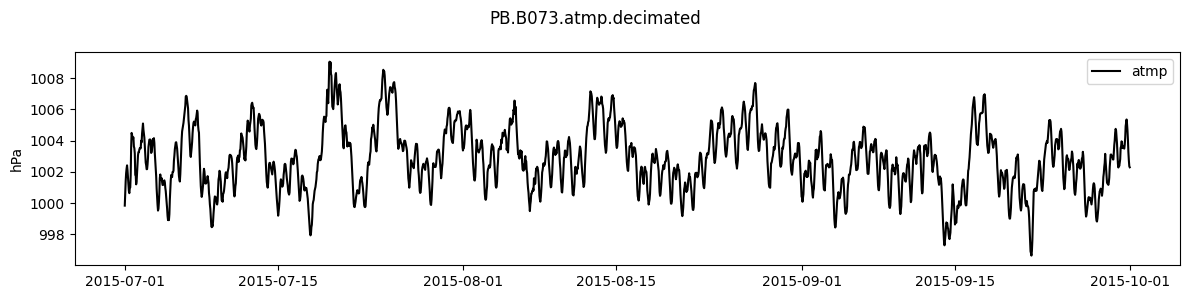

In [10]:
name = f"{network}.{station}.atmp.decimated"
atmp_decimated = atmp_raw.decimate_to_hourly(name=name, )
atmp_decimated.stats()
atmp_decimated.plot()

## Run BAYTAP to calculate tidal parameters and pressure response

In [11]:
#Requires docker.  downloads and runs an image containing BAYTAP-08, and returns results as python dictionaries
#need to supply BAYTAP with strain data, pressure data, as well as lat/long/elev for station
results = trend_offset_corrected.baytap_analysis(atmp_ts=atmp_decimated, 
                                                 latitude=meta.latitude, 
                                                 longitude=meta.longitude,
                                                 elevation=meta.elevation
                                                 )
results

Please note, this method expects continuous data in microstrain and pressure in hPa.


f5cf5934d846d71ea94a5c0dd493854921e604b14d69a9aea0189c91d08ca9a6
Docker container started.
Atmospheric pressure responses in microstrain/hPa and tidal parameters in degrees/nanostrain 
baytap
Docker processes finished. Container removed.


{'atmp_response': {'CH0': -0.010378,
  'CH1': -0.00841474,
  'CH2': -0.00692305,
  'CH3': -0.0067327},
 'tidal_params': {('CH0', 'M2', 'phz'): '-172.251',
  ('CH0', 'M2', 'amp'): '10.461',
  ('CH0', 'M2', 'doodson'): '2 0 0 0 0 0',
  ('CH0', 'O1', 'phz'): '-166.847',
  ('CH0', 'O1', 'amp'): '2.979',
  ('CH0', 'O1', 'doodson'): '1-1 0 0 0 0',
  ('CH0', 'P1', 'phz'): '-172.644',
  ('CH0', 'P1', 'amp'): '2.827',
  ('CH0', 'P1', 'doodson'): '1 1-2 0 0 0',
  ('CH0', 'K1', 'phz'): '153.526',
  ('CH0', 'K1', 'amp'): '1.513',
  ('CH0', 'K1', 'doodson'): '1 1 0 0 0 0',
  ('CH0', 'N2', 'phz'): '-178.802',
  ('CH0', 'N2', 'amp'): '0.372',
  ('CH0', 'N2', 'doodson'): '2-1 0 1 0 0',
  ('CH0', 'S2', 'phz'): '-168.575',
  ('CH0', 'S2', 'amp'): '6.374',
  ('CH0', 'S2', 'doodson'): '2 2-2 0 0 0',
  ('CH1', 'M2', 'phz'): '-148.400',
  ('CH1', 'M2', 'amp'): '7.158',
  ('CH1', 'M2', 'doodson'): '2 0 0 0 0 0',
  ('CH1', 'O1', 'phz'): '139.544',
  ('CH1', 'O1', 'amp'): '3.870',
  ('CH1', 'O1', 'doodson'): '

In [12]:
#Compare pressure response results to those in published metadata
#There will be some differences since this is only based on a small window of data
print("Calculated:", results['atmp_response'])
print("Published:", meta.atmp_response)

Calculated: {'CH0': -0.010378, 'CH1': -0.00841474, 'CH2': -0.00692305, 'CH3': -0.0067327}
Published: {'CH0': -0.012, 'CH1': -0.01, 'CH2': -0.0079, 'CH3': -0.0076}


In [13]:
#Compare tidal parameter results to those in the published metadata
#There will be some differences since this is only based on a small window of data
print("Calculated:", results['tidal_params'])
print("Published:", meta.tidal_params)

Calculated: {('CH0', 'M2', 'phz'): '-172.251', ('CH0', 'M2', 'amp'): '10.461', ('CH0', 'M2', 'doodson'): '2 0 0 0 0 0', ('CH0', 'O1', 'phz'): '-166.847', ('CH0', 'O1', 'amp'): '2.979', ('CH0', 'O1', 'doodson'): '1-1 0 0 0 0', ('CH0', 'P1', 'phz'): '-172.644', ('CH0', 'P1', 'amp'): '2.827', ('CH0', 'P1', 'doodson'): '1 1-2 0 0 0', ('CH0', 'K1', 'phz'): '153.526', ('CH0', 'K1', 'amp'): '1.513', ('CH0', 'K1', 'doodson'): '1 1 0 0 0 0', ('CH0', 'N2', 'phz'): '-178.802', ('CH0', 'N2', 'amp'): '0.372', ('CH0', 'N2', 'doodson'): '2-1 0 1 0 0', ('CH0', 'S2', 'phz'): '-168.575', ('CH0', 'S2', 'amp'): '6.374', ('CH0', 'S2', 'doodson'): '2 2-2 0 0 0', ('CH1', 'M2', 'phz'): '-148.400', ('CH1', 'M2', 'amp'): '7.158', ('CH1', 'M2', 'doodson'): '2 0 0 0 0 0', ('CH1', 'O1', 'phz'): '139.544', ('CH1', 'O1', 'amp'): '3.870', ('CH1', 'O1', 'doodson'): '1-1 0 0 0 0', ('CH1', 'P1', 'phz'): '167.505', ('CH1', 'P1', 'amp'): '2.929', ('CH1', 'P1', 'doodson'): '1 1-2 0 0 0', ('CH1', 'K1', 'phz'): '120.980', ('

## Calculate and plot corrections

Start from the original gauge microstrain

#### Calculate a simple linear trend correction

Calculating linear trend correction
    Trend Start: 2015-07-01 00:00:00
    Trend End: 2015-10-01 00:00:00
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


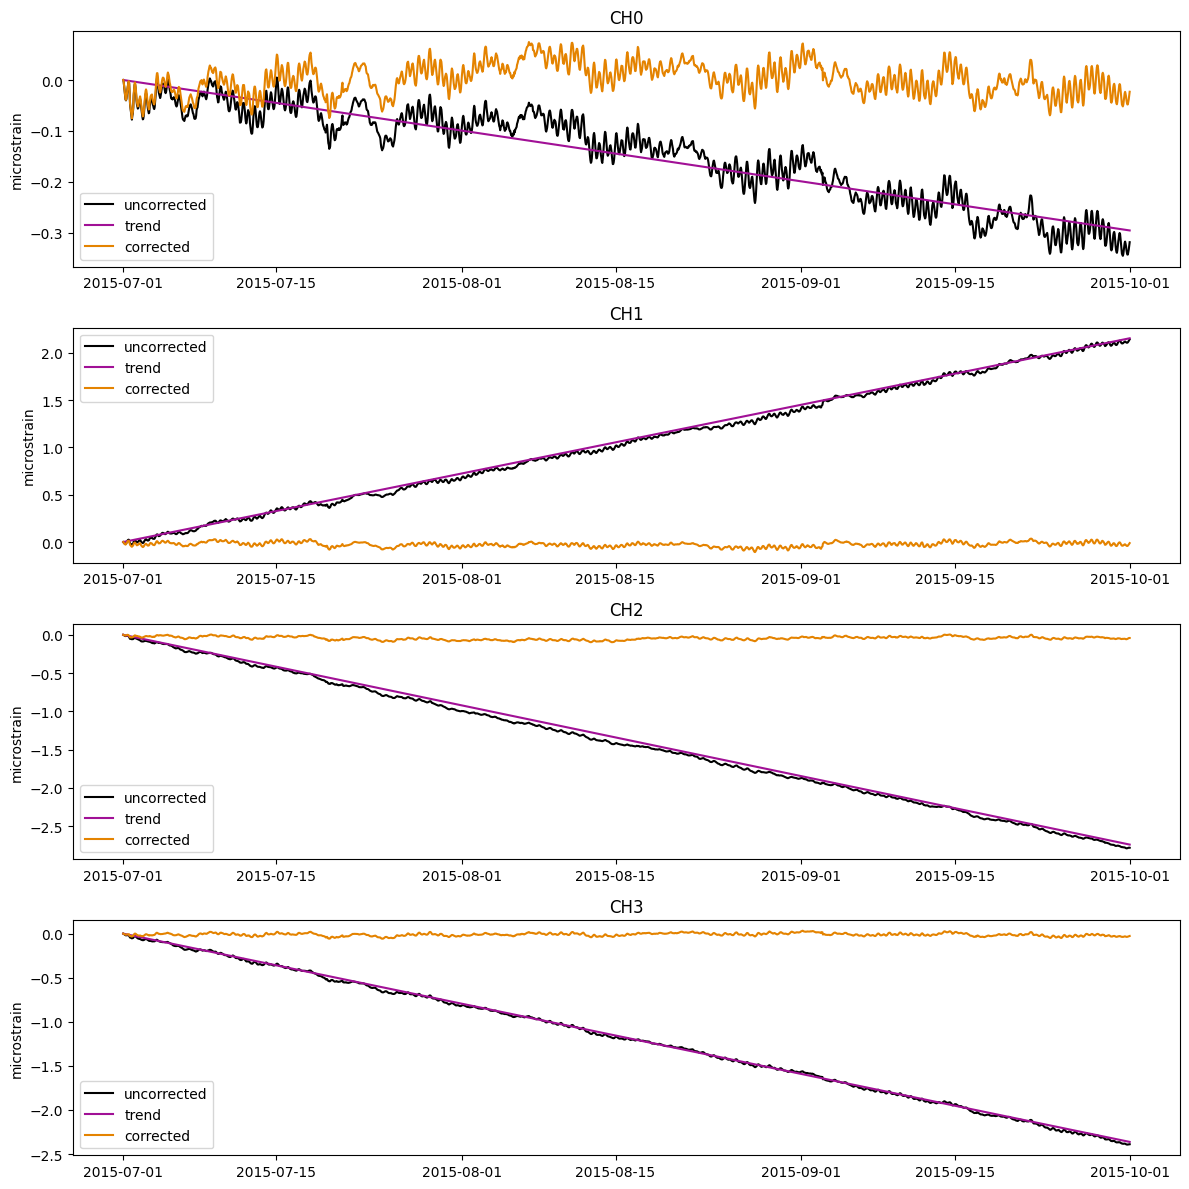

In [14]:
name = f"{network}.{station}.gauge.trend_c"
trend_c = gauge_microstrain.linear_trend_correction(name=name)

trend_corrected = gauge_microstrain.apply_corrections([trend_c])
plot_timeseries_comparison([gauge_microstrain, trend_c, trend_corrected], names=['uncorrected', 'trend', 'corrected'], zero=True)

#### Calculate a pressure correction using the generated pressure responses

Calculating pressure correction
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


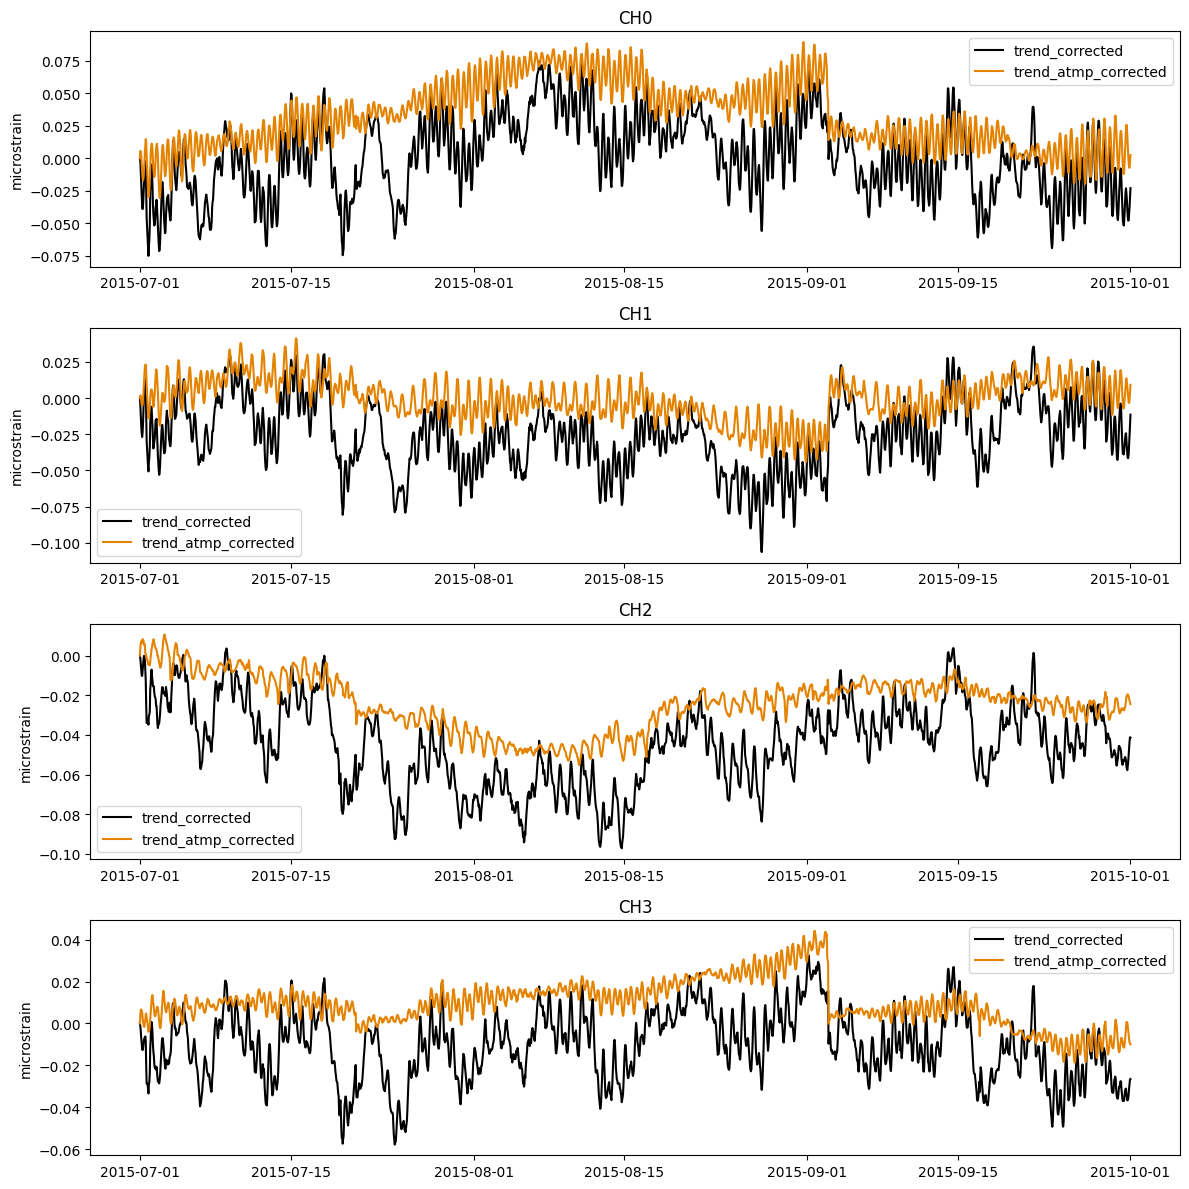

In [15]:
name = f"{network}.{station}.gauge.atmp_c"
atmp_c = atmp_decimated.calculate_pressure_correction(results['atmp_response'], name=name)
trend_atmp_corrected = trend_corrected.apply_corrections([atmp_c])

plot_timeseries_comparison([trend_corrected, trend_atmp_corrected], 
                            names=['trend_corrected', 'trend_atmp_corrected'], 
                            zero=True)



#### Calculate a tidal correction using the generated tidal parameters
This function downloads and runs a SPOTL image, and uses the hartid program to generate a timeseries of predicted tides at this location

Calculating tide correction


    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


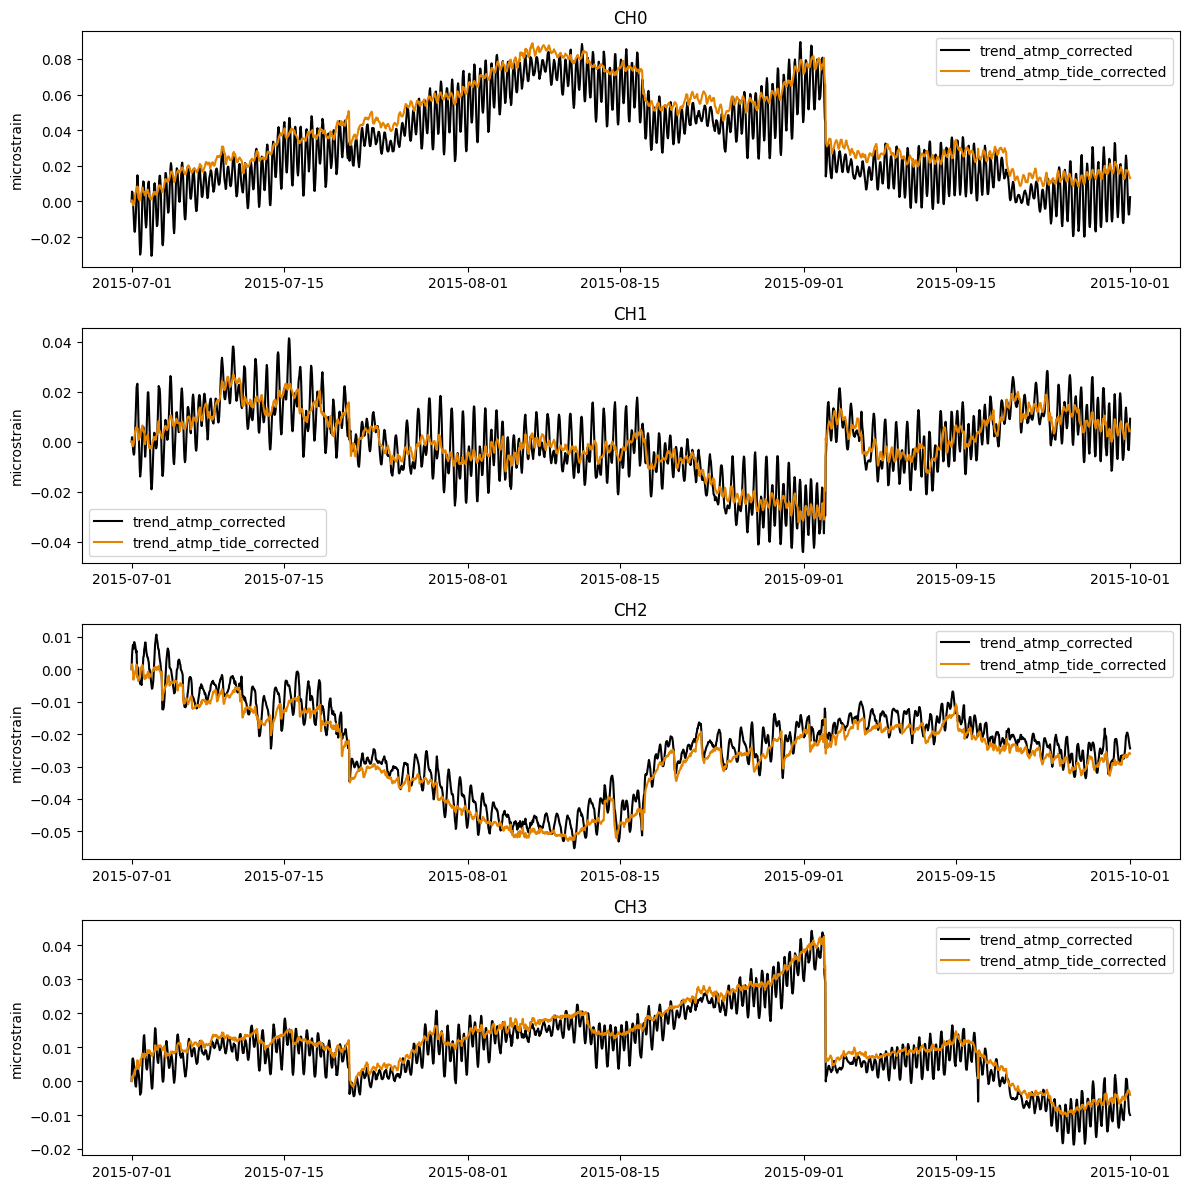

In [16]:
name = f"{network}.{station}.gauge.tide_c"
tide_c = trend_atmp_corrected.calculate_tide_correction(tidal_parameters=results['tidal_params'], longitude=meta.longitude, name=name)
trend_atmp_tide_corrected = trend_atmp_corrected.apply_corrections([tide_c])

plot_timeseries_comparison([trend_atmp_corrected, trend_atmp_tide_corrected], 
                           names=['trend_atmp_corrected', 'trend_atmp_tide_corrected',], 
                           zero=True)

#### Calculate offsets 
Offsets in this section are automatically detected via a simple first differencing algorithm. The best approach is to first correct for other known changes (tides, pressure, trend), then to apply the calculate_offsets function. This function finds jumps between consecutive datapoints that are above a cutoff limit, which is assigned from a user-specified value multiplied by a user-specified percentile of all first differences calculated for the gauge. For example, if a multiplier of 10 and percentile of 75% are used on a dataset whose first difference 75th percentile is 2 nanostrain, any jump in the data above 20 nanostrain will be flagged as an offset. This method is not perfect, but works well for certain situations.


Calculating offsets using cutoff percentile of 0.75 and limit multiplier of 10.
Using offset limits of [0.005026, 0.004768, 0.002659, 0.002214]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
Applying corrections
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


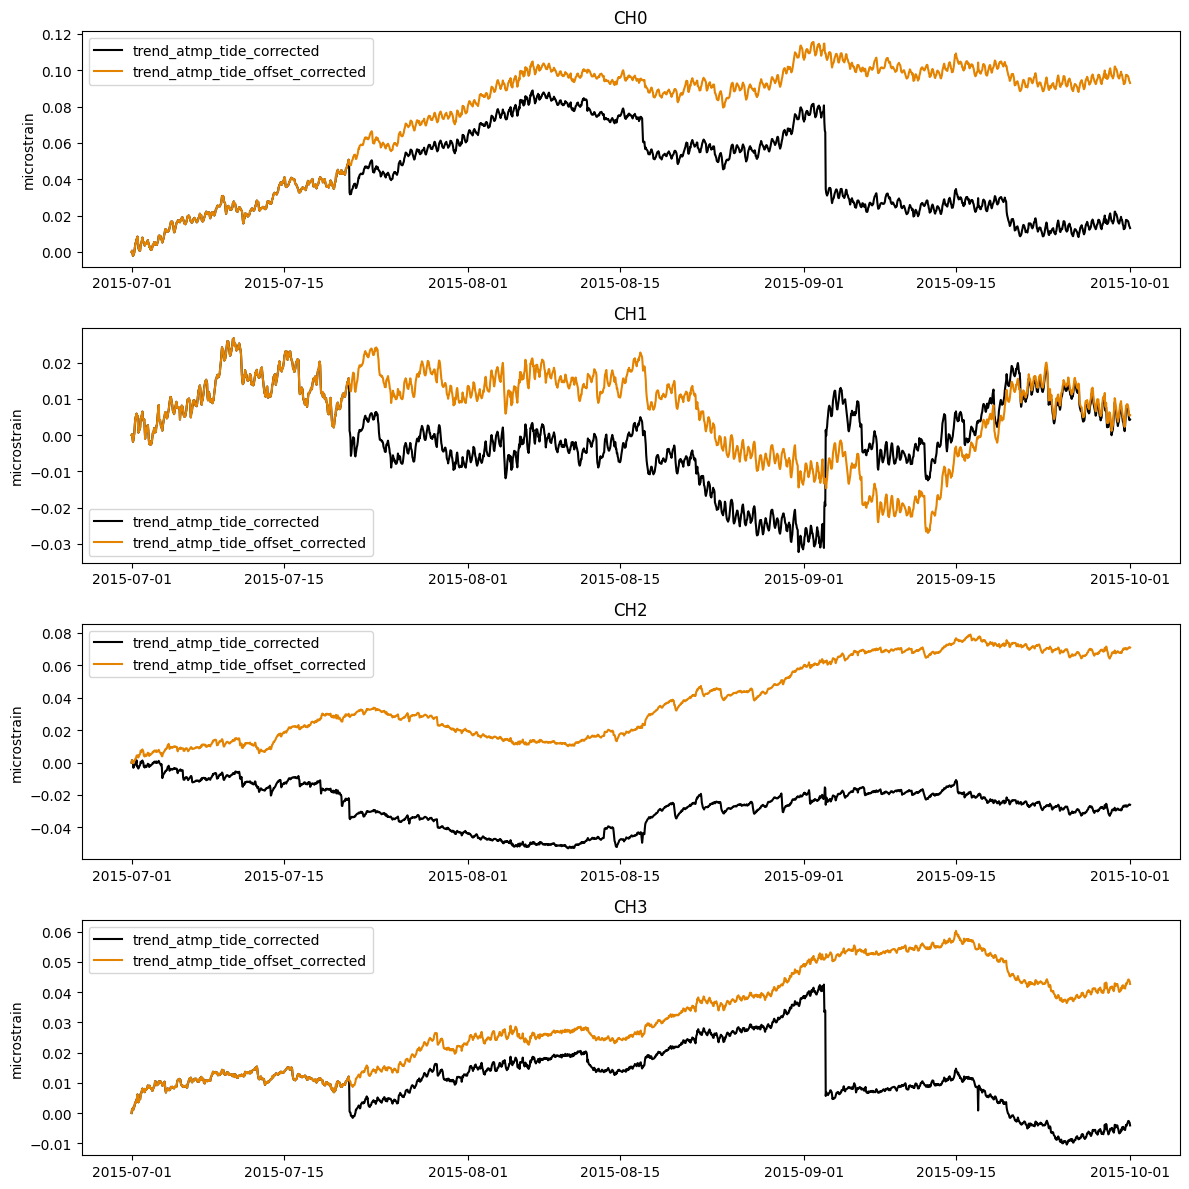

In [17]:
name = f"{network}.{station}.gauge.offset_c"
offset_c = trend_atmp_tide_corrected.calculate_offsets(limit_multiplier=10, cutoff_percentile=0.75, name=name)
trend_atmp_tide_offset_corrected = trend_atmp_tide_corrected.apply_corrections([offset_c])
#offset_c.plot()
plot_timeseries_comparison([trend_atmp_tide_corrected, trend_atmp_tide_offset_corrected], 
                           names=['trend_atmp_tide_corrected', 'trend_atmp_tide_offset_corrected',], 
                           zero=True)

## Plot fully corrected vs trend corrected data

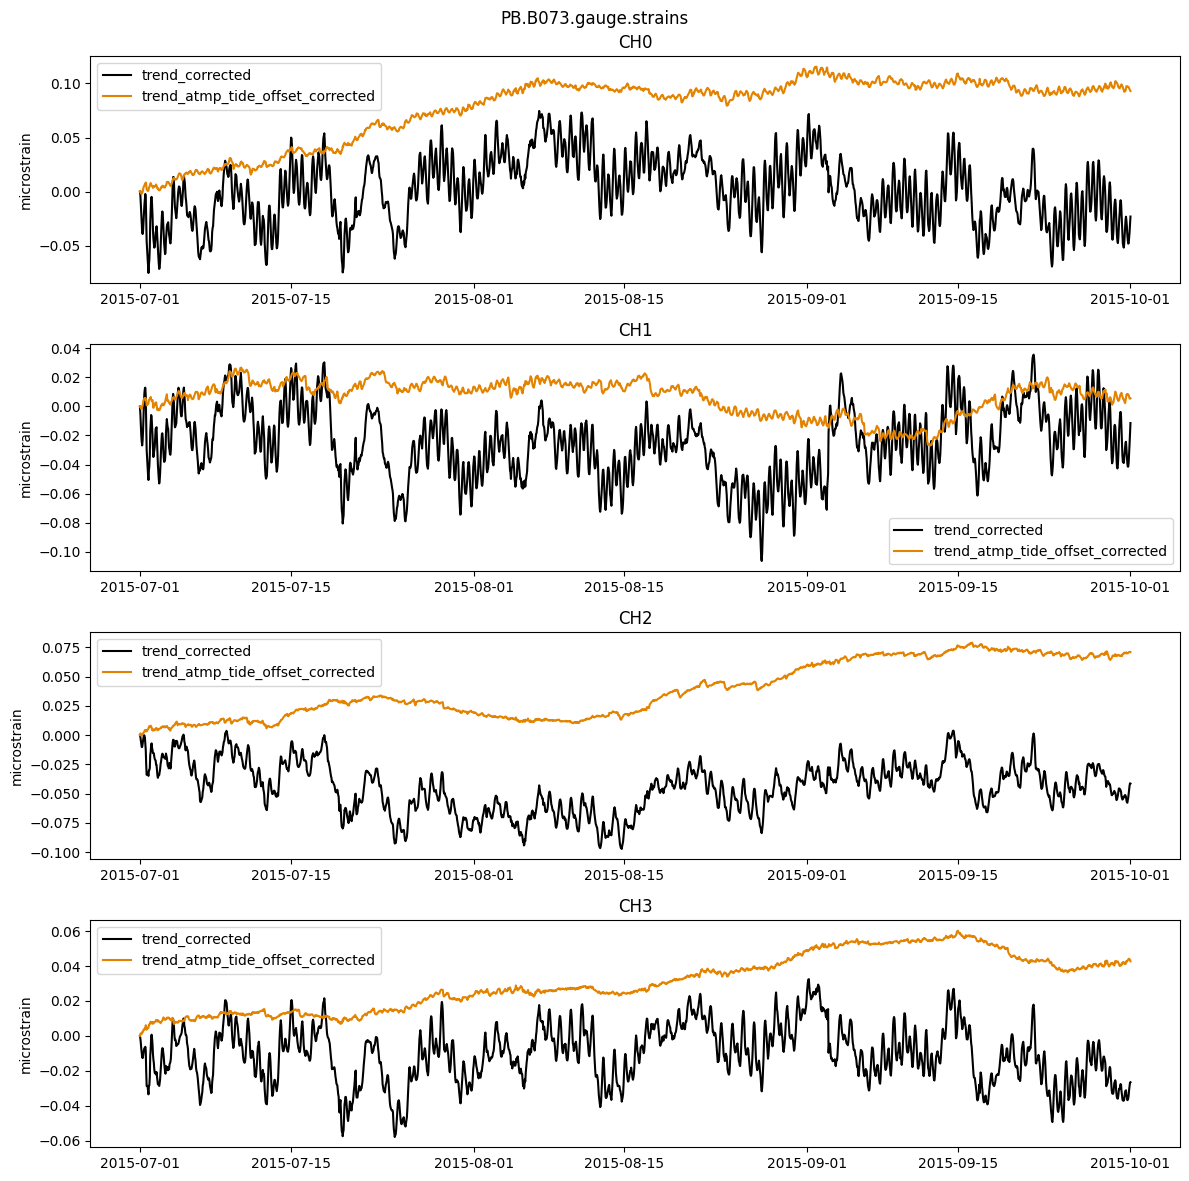

In [18]:
title=f"{network}.{station}.gauge.strains"
plot_timeseries_comparison([trend_corrected, trend_atmp_tide_offset_corrected], 
                           title=title, names=['trend_corrected', 'trend_atmp_tide_offset_corrected'], 
                           zero=True)